In [1]:
# Read the file tokens_clean.txt and store the cleaned captions in a dictionary
import json

content = None

with open ("/home/atharv_war/Downloads/Flickr30k-Image-Caption-Generator-Using-Deep-Learning-master (2)/data/textFiles/tokens_clean.txt", 'r') as file:
    content = file.read()

json_acceptable_string = content.replace("'", "\"")
content = json.loads(json_acceptable_string)

In [2]:
print(type(content))

<class 'dict'>


In [3]:
#Iterate over the captions word by word, and append each word to total_words
total_words = []

for key in content.keys():
    for caption in content[key]:
        for i in caption.split():
            total_words.append(i)

print("Total Words = %d" %len(total_words))

Total Words = 1955246


In [4]:
# Compute the frequency of occurrence of each word, and store it in a dictionary of word-freq
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)

print("Number of unique words = " + str(len(freq_cnt.keys())))

Number of unique words = 18079


In [5]:
# Store the word-freq pairs (from the dictionary freq_cnt) in a list, sorted in decreasing order of frequency
sorted_freq_cnt = sorted(freq_cnt.items(), reverse=True, key=lambda x:x[1])

In [6]:
threshold = 10

#Filter off those words whose frequency of occurrence in less than threshold
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
# Store these common words in total_words
total_words = [x[0] for x in sorted_freq_cnt]

print("Number of common unique words = " + str(len(total_words)))

Number of common unique words = 5136


PREPARE TRAIN AND TEST DATA

In [7]:
# Read training and testing image names

train_file_data = ""
test_file_data = ""

with open ("/home/atharv_war/Downloads/Flickr30k-Image-Caption-Generator-Using-Deep-Learning-master (2)/data/textFiles/flickr30k_train.txt", 'r') as file:
    train_file_data = file.read()

with open ("/home/atharv_war/Downloads/Flickr30k-Image-Caption-Generator-Using-Deep-Learning-master (2)/data/textFiles/flickr30k_test.txt", 'r') as file:
    test_file_data = file.read()

In [8]:
# Obtain a list of train and test images
train_data = [img_file_name for img_file_name in train_file_data.split("\n")[:-1]]
test_data = [img_file_name for img_file_name in test_file_data.split("\n")[:-1]]

# Obtain image ID from image file name
train_data = [image.split(".")[0] for image in train_data]
test_data = [image.split(".")[0] for image in test_data]

In [9]:
train_data[:5]

['1000092795', '10002456', '1000268201', '1000344755', '1000366164']

In [10]:
# For each imageID in train_data, store its captions in a dictionary 

train_content = {}

for imageID in train_data:
    train_content[imageID] = []
    for caption in content[imageID]:
        # Add a start sequence token in the beginning and an end sequence token at the end
        cap_to_append = "startseq " + caption + " endseq"
        train_content[imageID].append(cap_to_append)

In [11]:
train_content['1001896054']

['startseq a man with reflective safety clothes and ear protection drives a john deere tractor on a road  endseq',
 'startseq john deere tractors cruises down a street while the driver wears easy to see clothing  endseq',
 'startseq a man in a neon green and orange uniform is driving on a green tractor  endseq',
 'startseq a man in a tractor wearing headphones driving down a paved street  endseq',
 'startseq a man driving a john deere tractor on a main road in the country  endseq']

EXTRACT FEATURES FROM IMAGES USING RESNET50 ARCHIECTURE

In [12]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

model = ResNet50(weights = 'imagenet', input_shape = (224, 224, 3))

I0000 00:00:1744687513.870634    3860 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744687514.031847    3860 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744687514.032073    3860 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744687514.033550    3860 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [13]:
model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [14]:
from keras.models import Model
model_new = Model (model.input, model.layers[-2].output)

In [15]:
from keras.preprocessing import image
import numpy as np

def preprocess_image (img):
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img)

    # Convert 3D tensor to a 4D tendor
    img = np.expand_dims(img, axis=0)

    #Normalize image accoring to ResNet50 requirement
    img = preprocess_input(img)

    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].


(1, 224, 224, 3)


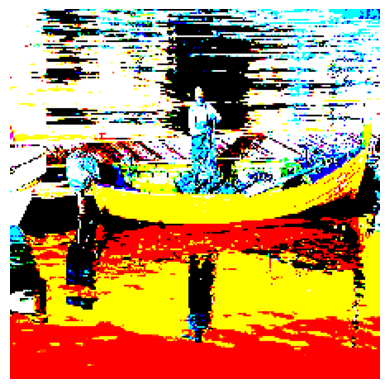

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

img = preprocess_image("data/flickr30k_images/4376178.jpg")
print(img.shape)
plt.imshow(img[0])
plt.axis('off')
plt.show()

In [17]:
# A wrapper function, which inputs an image and returns its encoding (feature vector)
def encode_image (img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)

    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [18]:
import os
import pickle
from tqdm import tqdm
from time import time

# File to save the encodings
encoding_file = "train_encodings.pkl"

# Check if saved encodings already exist
if os.path.exists(encoding_file):
    print("Loading saved encodings...")
    with open(encoding_file, "rb") as f:
        train_encoding = pickle.load(f)
else:
    print("Encoding images...")
    train_encoding = {}
    start_time = time()

    for imageID in tqdm(train_data, desc="Encoding images"):
        image_path = os.path.join("data", "flickr30k_images", imageID + ".jpg")
        train_encoding[imageID] = encode_image(image_path)

    end_time = time()
    print("Encoding complete. Total time taken:", end_time - start_time, "sec")

    # Save to file
    with open(encoding_file, "wb") as f:
        pickle.dump(train_encoding, f)
    print(f"Encodings saved to '{encoding_file}'")


Loading saved encodings...


In [19]:
"""from time import time

train_encoding = {}
# Create a dictionary of iamgeID and its feature vector

start_time = time()
for index, imageID in enumerate (train_data):
    image_path = "data/flickr30k_images/" + imageID + ".jpg"
    
    train_encoding[imageID] = encode_image(image_path)

    # Print progress
    if index%100 == 0:
        print("Encoding in progress... STEP", index)

end_time = time()
print("Total time taken:", end_time-start_time, "sec")"""

'from time import time\n\ntrain_encoding = {}\n# Create a dictionary of iamgeID and its feature vector\n\nstart_time = time()\nfor index, imageID in enumerate (train_data):\n    image_path = "data/flickr30k_images/" + imageID + ".jpg"\n    \n    train_encoding[imageID] = encode_image(image_path)\n\n    # Print progress\n    if index%100 == 0:\n        print("Encoding in progress... STEP", index)\n\nend_time = time()\nprint("Total time taken:", end_time-start_time, "sec")'

In [20]:
'''# Store the above computed features on the disk
# Use pickle to dump the entire data
import pickle

with open("encoded_train_features.pkl", "wb") as file:
    # Pickle allows to store any object as a file on the disk
    pickle.dump(train_encoding, file)'''

'# Store the above computed features on the disk\n# Use pickle to dump the entire data\nimport pickle\n\nwith open("encoded_train_features.pkl", "wb") as file:\n    # Pickle allows to store any object as a file on the disk\n    pickle.dump(train_encoding, file)'

In [21]:
import os
import pickle
from tqdm import tqdm
from time import time

# File to save the test encodings
test_encoding_file = "test_encodings.pkl"

# Check if saved encodings already exist
if os.path.exists(test_encoding_file):
    print("Loading saved test encodings...")
    with open(test_encoding_file, "rb") as f:
        test_encoding = pickle.load(f)
else:
    print("Encoding test images...")
    test_encoding = {}
    start_time = time()

    for imageID in tqdm(test_data, desc="Encoding test images"):
        image_path = os.path.join("data", "flickr30k_images", imageID + ".jpg")
        test_encoding[imageID] = encode_image(image_path)

    end_time = time()
    print("Encoding complete. Total time taken:", round(end_time - start_time, 2), "s")

    # Save encodings to file
    with open(test_encoding_file, "wb") as f:
        pickle.dump(test_encoding, f)
    print(f"Test encodings saved to '{test_encoding_file}'")


Loading saved test encodings...


In [22]:
"""test_encoding = {}
# Create a dictionary of iamgeID and its feature vector

start_time = time()
for index, imageID in enumerate (test_data):
    image_path = "data/flickr30k_images/" + imageID + ".jpg"
    
    test_encoding[imageID] = encode_image(image_path)

    # Print progress
    if index%100 == 0:
        print("Encoding in progress... STEP", index)

end_time = time()
print("Total time taken:", end_time-start_time, "s")"""

'test_encoding = {}\n# Create a dictionary of iamgeID and its feature vector\n\nstart_time = time()\nfor index, imageID in enumerate (test_data):\n    image_path = "data/flickr30k_images/" + imageID + ".jpg"\n    \n    test_encoding[imageID] = encode_image(image_path)\n\n    # Print progress\n    if index%100 == 0:\n        print("Encoding in progress... STEP", index)\n\nend_time = time()\nprint("Total time taken:", end_time-start_time, "s")'

In [23]:
'''import pickle


with open("encoded_test_features.pkl", "wb") as file:
    pickle.dump(test_encoding, file)'''

'import pickle\n\n\nwith open("encoded_test_features.pkl", "wb") as file:\n    pickle.dump(test_encoding, file)'

PREPROCESS THE CAPTIONS

In [24]:
# Create the word-to-index and index-to-word mappings
word_to_index = {}
index_to_word = {}

for i, word in enumerate(total_words):
    word_to_index[word] = i+1
    index_to_word[i+1] = word

In [25]:
print(len(index_to_word))

5136


In [26]:
print(index_to_word[5])
print(word_to_index['is'])

and
7


In [27]:
# Add startseq and endseq also to the mappings
index_to_word[5137] = 'startseq'
word_to_index['startseq'] = 5137

index_to_word[5138] = 'endseq'
word_to_index['endseq'] = 5138

VOCAB_SIZE = len(word_to_index) + 1

In [28]:
print(VOCAB_SIZE)

5139


In [29]:
import pickle
with open("data/textFiles/word_to_idx.pkl", "wb") as file:
    pickle.dump(word_to_index, file)

In [30]:
with open("data/textFiles/idx_to_word.pkl", "wb") as file:
    pickle.dump(index_to_word, file)

In [31]:
# Get the maximum length of a caption
max_len = 0

for cap_list in train_content.keys():
    for caption in train_content[cap_list]:
        max_len = max(max_len, len(caption.split()))

In [32]:
print(max_len)

80


In [33]:
# Get the Glove word Embeddings
# This contains 50-dimensional embeddings for 6 Billion English words
file = open("glove.6B.50d.txt",encoding='utf8')

In [34]:
# Create a mapping from word to embedding
embeddings_index = {} # empty dictionary

for line in file:
    values = line.split()

    word = values[0]
    coefs = np.array (values[1:], dtype='float')
    embeddings_index[word] = coefs

file.close()

In [35]:
embeddings_index["apple"]

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [36]:
embedding_dim = 50

embedding_matrix = np.zeros((VOCAB_SIZE, embedding_dim))

for word, i in word_to_index.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [37]:
embedding_matrix.shape

(5139, 50)

DEFINE MODEL ARCHITECTURE

In [38]:
from keras.layers import Input, Dense, Dropout, Embedding, LSTM

#Convert feature vector of image to smaller vector

#Output of ResNet goes into following input layer 
inp_img_features = Input(shape=(2048,))

inp_img1 = Dropout(0.3)(inp_img_features)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [39]:
#Now take Captions as input

#Actual input size will be (batch_size x max_length_of_caption)
#But here we specify only for one example
inp_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=VOCAB_SIZE, output_dim=50, mask_zero=True)(inp_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)
# inp_cap3 captures the entire sentence that has been generated till now

In [40]:
from keras.layers import add

# Decode the inputs

# So, an image (224x224x3) goes through ResNet50
# Then as 2048 dimensional it goes through the above earlier architecture
# The final output is inp_img2 (256 dimensional) which now goes through the Decoder 

# Similarly for the captions which initially have shape (batch_size x max_len)
# Then after passing through Embedding layer comes out as (batch_size x max_len x 50(embedding_size)))
# Then it passes through the above LSTM layer and comes out as inp_cap3 (a 256 dimensional vector)

# Add the two above tensors
decoder1 = add([inp_img2, inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(VOCAB_SIZE, activation='softmax')(decoder2)

# Combined model
model = Model (inputs=[inp_img_features, inp_cap], outputs=outputs)

In [41]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 80)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 80, 50)    │    256,950 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 80, 50)    │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 80)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    314,368 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5139)      │  1,320,723 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,482,377 (9.47 MB)

 Trainable params: 2,482,377 (9.47 MB)

 Non-trainable params: 0 (0.00 B)

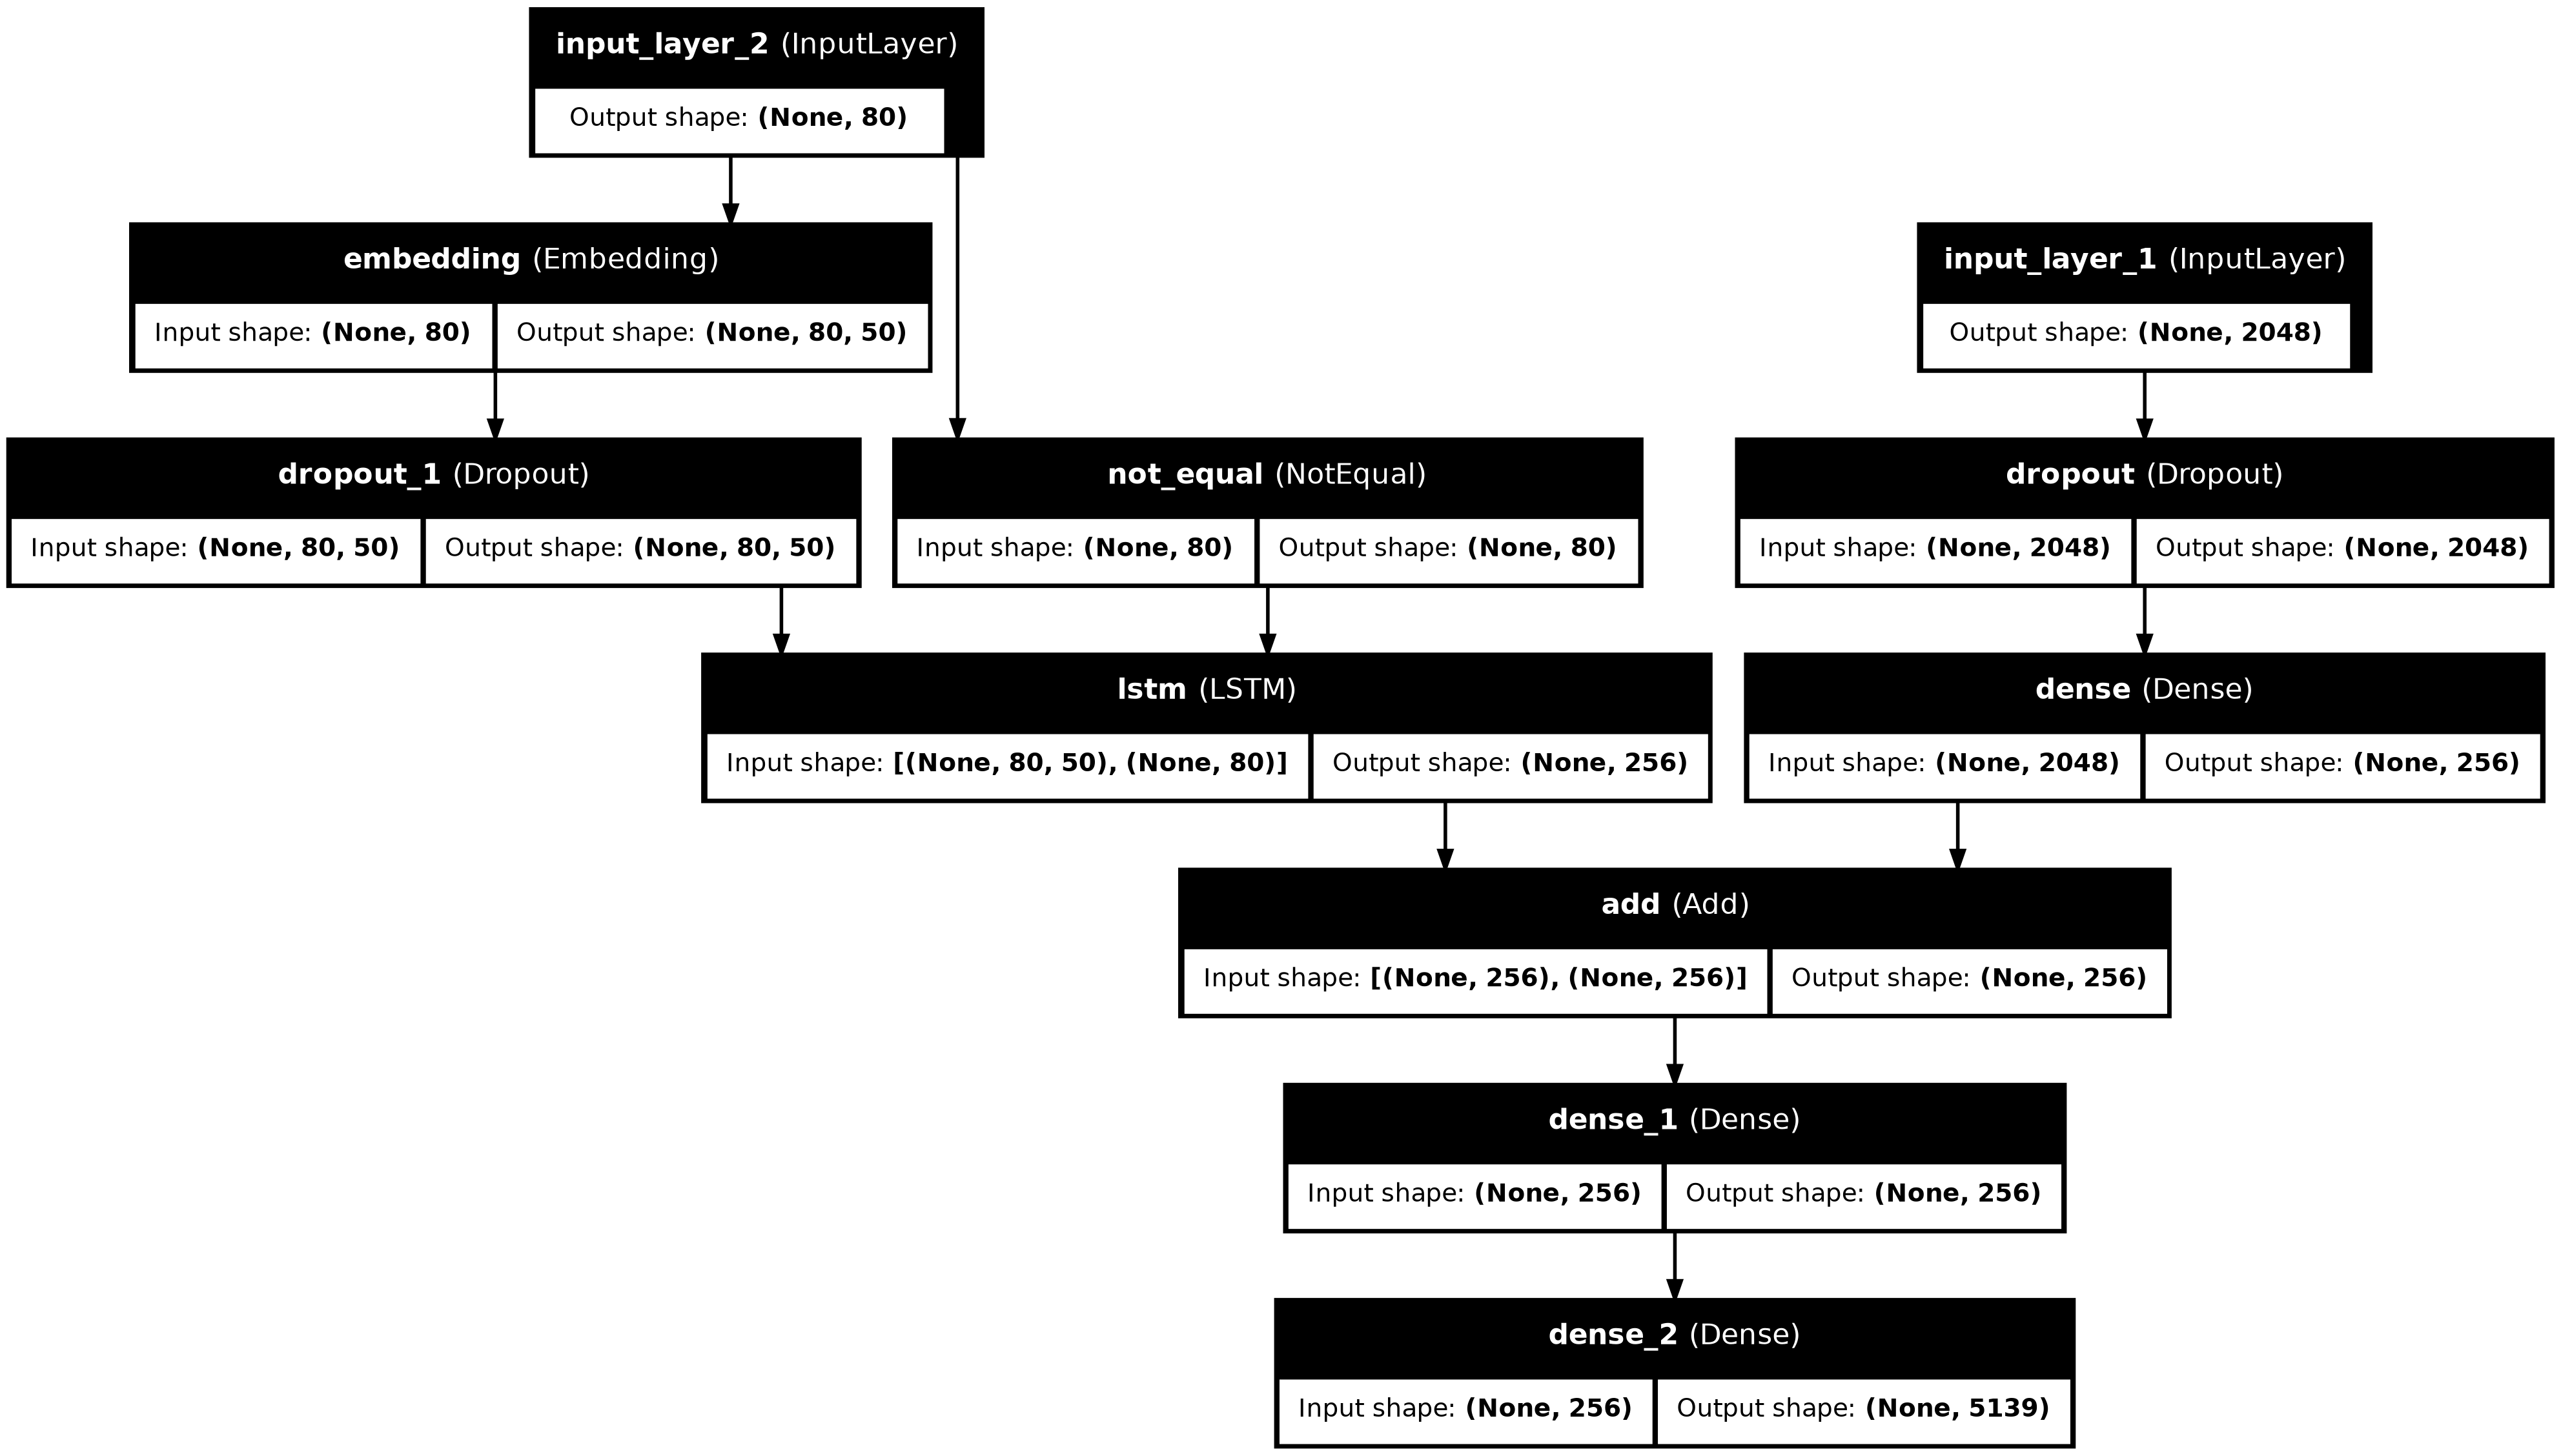

In [43]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [44]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [45]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

In [46]:
from keras.utils import Sequence
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

class ImageCaptioningGenerator(Sequence):
    def __init__(self, train_content, train_encoding, word_to_index, max_len, batch_size, vocab_size, **kwargs):
        super().__init__(**kwargs)  # ✅ this is the fix!
        self.train_content = list(train_content.items())
        self.train_encoding = train_encoding
        self.word_to_index = word_to_index
        self.max_len = max_len
        self.batch_size = batch_size
        self.vocab_size = vocab_size

    def __len__(self):
        return int(np.ceil(len(self.train_content) / float(self.batch_size)))



    def __getitem__(self, idx):
        X1, X2, y = [], [], []
        start = idx * self.batch_size
        end = start + self.batch_size
        batch_items = self.train_content[start:end]

        for imageID, cap_list in batch_items:
            image = self.train_encoding[imageID]
            for caption in cap_list:
                idx_seq = [self.word_to_index[word] for word in caption.split() if word in self.word_to_index]
    
                for i in range(1, len(idx_seq)):
                    xi = idx_seq[0:i]
                    yi = idx_seq[i]
    
                    xi = pad_sequences([xi], maxlen=self.max_len, value=0, padding='post')[0]
                    yi = to_categorical([yi], num_classes=self.vocab_size)[0]
    
                    X1.append(image)
                    X2.append(xi)
                    y.append(yi)

        return ([np.array(X1), np.array(X2)], np.array(y))  # ✅ must return a tuple!


    





''' def __getitem__(self, idx):
            X1, X2, y = [], [], []
            start = idx * self.batch_size
            end = start + self.batch_size
            batch_items = self.train_content[start:end]

        for imageID, cap_list in batch_items:
            image = self.train_encoding[imageID]
            for caption in cap_list:
                idx_seq = [self.word_to_index[word] for word in caption.split() if word in self.word_to_index]

                for i in range(1, len(idx_seq)):
                    xi = idx_seq[0:i]
                    yi = idx_seq[i]

                    xi = pad_sequences([xi], maxlen=self.max_len, value=0, padding='post')[0]
                    yi = to_categorical([yi], num_classes=self.vocab_size)[0]

                    X1.append(image)
                    X2.append(xi)
                    y.append(yi)

        return [np.array(X1), np.array(X2)], np.array(y)'''


" def __getitem__(self, idx):\n            X1, X2, y = [], [], []\n            start = idx * self.batch_size\n            end = start + self.batch_size\n            batch_items = self.train_content[start:end]\n\n        for imageID, cap_list in batch_items:\n            image = self.train_encoding[imageID]\n            for caption in cap_list:\n                idx_seq = [self.word_to_index[word] for word in caption.split() if word in self.word_to_index]\n\n                for i in range(1, len(idx_seq)):\n                    xi = idx_seq[0:i]\n                    yi = idx_seq[i]\n\n                    xi = pad_sequences([xi], maxlen=self.max_len, value=0, padding='post')[0]\n                    yi = to_categorical([yi], num_classes=self.vocab_size)[0]\n\n                    X1.append(image)\n                    X2.append(xi)\n                    y.append(yi)\n\n        return [np.array(X1), np.array(X2)], np.array(y)"

In [47]:
epochs = 15
batch_size = 5
steps = len(train_content)//batch_size

In [48]:
import tensorflow as tf

output_signature = (
    (
        tf.TensorSpec(shape=(None, 2048), dtype=tf.float32),  # Image features with batch dimension
        tf.TensorSpec(shape=(None, max_len), dtype=tf.int32)    # Caption sequences with batch dimension
    ),
    tf.TensorSpec(shape=(None, VOCAB_SIZE), dtype=tf.float32)   # One-hot labels with batch dimension
)


In [60]:
'''import tensorflow as tf

output_signature = (
    (
        tf.TensorSpec(shape=(None, 2048), dtype=tf.float32),  # Image features with batch dimension
        tf.TensorSpec(shape=(None, max_len), dtype=tf.int32)    # Caption sequences with batch dimension
    ),
    tf.TensorSpec(shape=(None, VOCAB_SIZE), dtype=tf.float32)   # One-hot labels with batch dimension
)'''


In [49]:
generator = ImageCaptioningGenerator(
    train_content=train_content,
    train_encoding=train_encoding,
    word_to_index=word_to_index,
    max_len=max_len,
    batch_size=batch_size,
    vocab_size=VOCAB_SIZE
)

for i in range(epochs):
    model.fit(generator, epochs=1)
    model.save(f'model_{i}.h5')

TypeError: `output_signature` must contain objects that are subclass of `tf.TypeSpec` but found <class 'list'> which is not.

In [46]:
'''from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def data_generator (train_content, train_encoding, word_to_index, max_len, batch_size):
    X1, X2, y = [], [], []
    n = 0

    while True:
        for imageID, cap_list in train_content.items():
            n += 1

            image = train_encoding [imageID]

            for caption in cap_list:
                idx_seq = [word_to_index[word] for word in caption.split() if word in word_to_index]

                for i in range (1, len(idx_seq)):
                    xi = idx_seq[0 : i] # The input sequence of words
                    yi = idx_seq[i] # The next word after the above sequence (this is expected to be predicted)

                    # Add a padding of zeros ao lengths of input sequences become equal
                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0] # Take the first row only, since this method inputs & returns a 2D array
                    # Convert the expected word to One Hot vector notation
                    yi = to_categorical([yi], num_classes=VOCAB_SIZE)[0]

                    X1.append(image)
                    X2.append(xi)
                    y.append(yi)

                if n==batch_size:
                    yield ([np.array(X1), np.array(X2)], np.array(y))
                    
                    X1, X2, y = [], [], []
                    n=0'''

"from keras.preprocessing.sequence import pad_sequences\nfrom keras.utils import to_categorical\n\ndef data_generator (train_content, train_encoding, word_to_index, max_len, batch_size):\n    X1, X2, y = [], [], []\n    n = 0\n\n    while True:\n        for imageID, cap_list in train_content.items():\n            n += 1\n\n            image = train_encoding [imageID]\n\n            for caption in cap_list:\n                idx_seq = [word_to_index[word] for word in caption.split() if word in word_to_index]\n\n                for i in range (1, len(idx_seq)):\n                    xi = idx_seq[0 : i] # The input sequence of words\n                    yi = idx_seq[i] # The next word after the above sequence (this is expected to be predicted)\n\n                    # Add a padding of zeros ao lengths of input sequences become equal\n                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0] # Take the first row only, since this method inputs & returns a 2D arr

TRAIN THE MODEL

In [47]:
epochs = 15
batch_size = 5
steps = len(train_content)//batch_size

In [53]:
import tensorflow as tf

output_signature = (
    (
        tf.TensorSpec(shape=(None, 2048), dtype=tf.float32),  # Image features with batch dimension
        tf.TensorSpec(shape=(None, max_len), dtype=tf.int32)    # Caption sequences with batch dimension
    ),
    tf.TensorSpec(shape=(None, VOCAB_SIZE), dtype=tf.float32)   # One-hot labels with batch dimension
)


In [54]:
def generator_fn():
    return ImageCaptioningGenerator(
        train_content=train_content,
        train_encoding=train_encoding,
        word_to_index=word_to_index,
        max_len=max_len,
        batch_size=batch_size,
        vocab_size=VOCAB_SIZE
    )


In [50]:
'''output_signature = (
    (
        tf.TensorSpec(shape=(2048,), dtype=tf.float32),      # image vector
        tf.TensorSpec(shape=(max_len,), dtype=tf.int32)      # caption input
    ),
    tf.TensorSpec(shape=(VOCAB_SIZE,), dtype=tf.float32)     # one-hot encoded output
)'''


In [55]:
'''dataset = tf.data.Dataset.from_generator(
    generator_fn,
    output_signature=output_signature
)
'''

In [56]:
'''for i in range(epochs):
    model.fit(dataset, steps_per_epoch=steps, epochs=1)
    model.save(f'model_{i}.h5')
'''

ValueError: Creating variables on a non-first call to a function decorated with tf.function.

In [48]:
'''import tensorflow as tf

# Example of output_signature definition for the generator
output_signature = (
    tf.TensorSpec(shape=(None, None), dtype=tf.float32),  # Adjust the shape and dtype as necessary
    tf.TensorSpec(shape=(None,), dtype=tf.int32)          # For the labels (or captions)
)

# Adjust the generator to match the signature
generator = ImageCaptioningGenerator(
    train_content=train_content,
    train_encoding=train_encoding,
    word_to_index=word_to_index,
    max_len=max_len,
    batch_size=batch_size,
    vocab_size=VOCAB_SIZE
)

# Use from_generator with the correct output_signature
dataset = tf.data.Dataset.from_generator(
    generator,
    output_signature=output_signature
)

# Then fit the model
for i in range(epochs):
    model.fit(dataset, epochs=1, verbose=1)
    model.save(f'model_{i}.h5')'''


TypeError: `generator` must be a Python callable.

In [ ]:
'''generator = ImageCaptioningGenerator(
    train_content=train_content,
    train_encoding=train_encoding,
    word_to_index=word_to_index,
    max_len=max_len,
    batch_size=batch_size,
    vocab_size=VOCAB_SIZE
)

for i in range(epochs):
    model.fit(generator, epochs=1, verbose=1)
    model.save(f'model_{i}.h5')'''


In [ ]:
'''for i in range(epochs):
    # Create an instance of the generator
    generator = data_generator(train_content, train_encoding, word_to_index, max_len, batch_size)
    model.fit(generator, steps_per_epoch=steps)
    model.save('model_' + str(i) + '.h5')'''

In [ ]:
'''for i in range(epochs):
    generator = data_generator(train_content, train_encoding, word_to_index, max_len, batch_size)
    model.fit(generator,
              steps_per_epoch=steps,
              epochs=1,
              use_multiprocessing=False,  # <- important
              workers=1,                  # <- avoid multiprocessing issues
              verbose=1)
    model.save(f'model_{i}.h5')'''


In [ ]:
'''for i in range(epochs):
    generator = data_generator(train_content, train_encoding, word_to_index, max_len, batch_size)
    model.fit(x=generator, steps_per_epoch=steps)
    model.save(f'model_{i}.h5')
'''

In [ ]:
model.load_weights('./model_checkpoints/model_14.h5')

In [ ]:
images = './data/flickr30k_images/'

In [ ]:
from pickle import dump, load
with open("./encoded_test_features.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_len):
        sequence = [word_to_index[w] for w in in_text.split() if w in word_to_index]
        sequence = pad_sequences([sequence], maxlen=max_len)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
z = 0

In [ ]:
#z = 0
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))
print(pic)

In [ ]:
test_content = {}

for imageID in test_data:
    test_content[imageID] = []
    for caption in content[imageID]:
        # Add a start sequence token in the beginning and an end sequence token at the end
        cap_to_append = caption
        test_content[imageID].append(cap_to_append)

In [ ]:
x = 0
pic = list(encoding_test.keys())[x]
test_content[pic]

In [5]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

x = 3
pic = list(encoding_test.keys())[x]
test_content[pic]


reference = test_content[pic]
#pic = list(encoding_test.keys())[1]
print(pic)
img = 'twodogs.jpg'
e = encoding_test[pic].reshape(1,2048)
#image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic+'.jpg')
#x=plt.imread(img)
plt.imshow(x)
# plt.show()
caption = greedySearch(e)
print("Greedy Search Caption:",caption)
print()
print('Reference 1:',reference)

print()
print('BLEU-1:', round(sentence_bleu(reference, caption),3))

NameError: name 'encoding_test' is not defined